## **OCR(Optical Character Recognition)**  

- 광학 문자 인식
- 이미지에서 문자를 인식하는 기술 
- 문자 존재를 Detection 하고, 어떤 문자인지 판독하는 Recognition

In [ ]:
# test_image에 있는 image를 테스트 이미지로 사용 

import os 
path_dir = '/Users/js8456/google_drive/Colab_Notebook/aiffel_lms/E18_OCR/test_image'
image_path = sorted(os.listdir(path_dir))

In [26]:
# image path list 생성

image_path_list = []

for i in range(len(image_path)):
    image_path_list.append(path_dir + '/' + image_path[i])

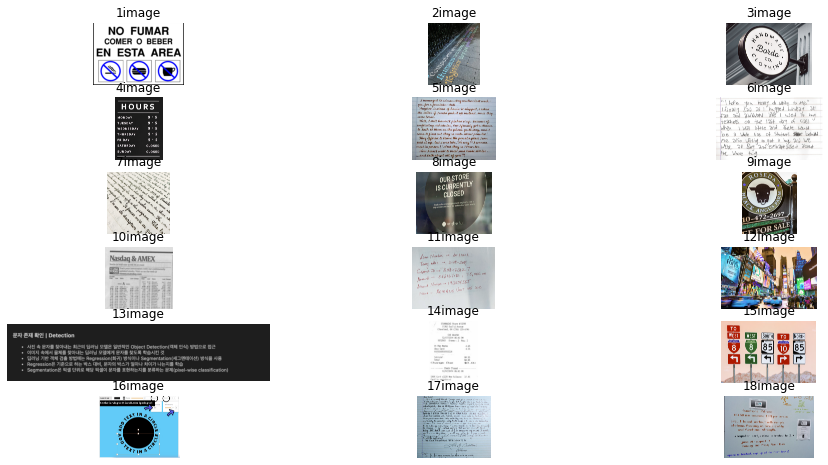

In [27]:
# raw data 확인
import matplotlib.pyplot as plt
import cv2

fig = plt.figure(figsize=(16,8))
rows = 6
columns = 3

for i in range(len(image_path)):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(cv2.imread(image_path_list[i]))
    plt.axis('off')
    plt.title(f'{i+1}image')


----------------
----------------

### **문자 존재 확인 | Detection**  

- 사진 속 문자를 찾아내는 최근의 딥러닝 모델은 일반적인 Object Detection(객체 인식) 방법으로 접근
- 이미지 속에서 물체를 찾아내는 딥러닝 모델에게 문자를 찾도록 학습시킨 것 
- 딥러닝 기반 객체 검출 방법에는 Regression(회귀) 방식이나 Segmentation(세그멘테이션) 방식을 사용
- Regression은 기준으로 하는 박스 대비, 문자의 박스가 얼마나 차이가 나는지를 학습
- Segmentation은 픽셀 단위로 해당 픽셀이 문자를 표현하는지를 분류하는 문제(pixel-wise classification)


### **문자 판독 | Recognition**

- 이미지 문제보다는 자연어 처리에서 많은 영감을 받음 
- 이미지 내의 문자 인식 모델의 기본적인 방법 중 하나가 바로 ***CNN과 RNN을 결합한 CRNN 모델***
- 이미지 내의 텍스트와 연관된 특징을 CNN을 통해 추출한 후에 스텝 단위의 문자 정보를 RNN으로 인식하는 것

## **1. keras-ocr | OCR 첫번째 방법**
- 텐서플로우를 기반으로 모델을 구현해서 OCR을 직접 실행 

- keras-ocr은 텐서플로우의 케라스 API를 기반으로 이미지 속 문자를 읽는 End-to-End OCR을 할 수 있게 해줌
- 공식 문서에도 나와 있듯, 검출 모델로는 CRAFT(Character Region Awareness for Text Detection)를 사용하고, 인식 모델로는 앞에서 설명한 CRNN을 사용

#### **[TIP] Anaconda에서 keras-ocr 사용하기**  

1. First Method
- `conda install -c anaconda keras-ocr` 
- anaconda에서 keras_ocr install이 불가능하다고 나옴  
![conda install -c anaconda keras-ocr 설치 에러 캡쳐 이미지](./e18_kerasocr_error_1.png.png)

- conda activate 한 후, pip 로 install 한 다음에 사용하고자 pip install  
![pip install keras-ocr 설치 이미지](./e18_kerasocr_pip설치_2.png)
- `pip list | grep keras-ocr`로 설치 여부 확인 


#### **[TIP] keras_ocr.pipeline.Pipeline**  

- keras_ocr.pipeline.Pipeline() 는 인식을 위한 파이프라인을 생성
- 초기화 과정에서 미리 학습된 모델의 가중치(weight)를 불러오게 됨 
- detector, recognizer의 pretrained된 weights 다운
- 검출기와 인식기를 위한 가중치를 각 각 불러옴 
- [keras_ocr 공식문서](https://keras-ocr.readthedocs.io/en/latest/index.html)



In [24]:
import keras_ocr

# detector, recognizer의 pretrained된 weights 다운 
pipeline = keras_ocr.pipeline.Pipeline()

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 80 from C header, got 88 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


Looking for /Users/js8456/.keras-ocr/craft_mlt_25k.h5


2021-09-21 11:26:39.329981: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Looking for /Users/js8456/.keras-ocr/crnn_kurapan.h5


#### [TIP] numpy와 tf 충돌 에러 -> Solved :)    

Cannot convert a symbolic Tensor (lambda_1/meshgrid/Size_1:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported  

- 위의 에러가 지금까지 지속적으로 occurred됨 
- 온전히 해결하고자 다양한 방법을 search 함 
- 가장 많이 말하는 해결 방법은 numpy version을 1.9대로 내리라는 것이었는데 해결되지 않음 
- [github_tensorflow 오류 해결 방법 url](https://github.com/tensorflow/models/issues/9706) 여기 참고해서 tensorflow 내 array_ops.py 내용 수정하고자 함

- 해당 파일의 2900줄에 있음 
- 로컬 내 파일 위치는 : /opt/anaconda3/envs/tf2/lib/python3.8/site-packages/tensorflow/python/ops 
- 아래와 같은 방법으로 해결함  


In [ ]:
# # Just open the file in any editor
# # Add the following lines in starting to import

# from tensorflow.python.ops.math_ops import reduce_prod
# # then search for def _constant_if_small and then replace the entire function to this :

# def _constant_if_small(value, shape, dtype, name):
#     try:
#         if reduce_prod(shape) < 1000:
#         return constant(value, shape=shape, dtype=dtype, name=name)
#     except TypeError:
#     # Happens when shape is a Tensor, list with Tensor elements, etc.
#     pass
# return None

#### Using pretrained models | Recognizer  

- 파이프라인의 recognize()에 이미지 input
- url을 사용 

In [28]:
# Recognizer 인식기에 이미지를 추가

images = [keras_ocr.tools.read(image) for image in image_path_list] # 이미지 추출 
prediction_groups = [pipeline.recognize([image]) for image in image_path_list] 

# 공식 홈에서는 아래의 코드를 사용 
# prediction_groups = [pipeline.recognize(images)] 
# 이거로 하면 왜 아래 코드에서 하나만 나오고 에러가 occurred 
# 첫번째 prediction_groups 코드는 image url안의 url을 pipeline.recognize함수에 요소로 넣는 것인데 
# 공홈 코드는 pipeline.recognize함수에 keras_ocr.tools.read로 읽은 url을 넣는거야 
# 쨌든 다른 결과를 넣는 것
# url을 넣는 것과 url을 읽은 이미지를 넣는것은 다르니까 

2021-09-21 11:29:27.328545: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


# [TIP] keras_ocr.tools.read 확인  

[keras_ocr.tools 참고페이지](https://keras-ocr.readthedocs.io/en/latest/_modules/keras_ocr/tools.html)
- source code for keras_ocr.tools 의 def read를 확인 

In [ ]:
# def read(filepath_or_buffer: typing.Union[str, io.BytesIO]):
#     # """Read a file into an image object

#     # Args:
#     #     filepath_or_buffer: The path to the file, a URL, or any object
#     #         with a `read` method (such as `io.BytesIO`)
#     # """
# # 위와 같은 내용의 함수라고 주석 달아놓음 

# # return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# # return은 rgb 이미지로 나옴 

# class Recognizer:
#     """A text detector using the CRNN architecture.
#     Args:
#         alphabet: The alphabet the model should recognize.
#         build_params: A dictionary of build parameters for the model.
#             See `keras_ocr.recognition.build_model` for details.
#         weights: The starting weight configuration for the model.
#         include_top: Whether to include the final classification layer in the model (set
#             to False to use a custom alphabet).
#     """

#### 인식된 결과를 pyplot으로 시각화
- 내부적으로 recognize() 는 검출기와 인식기를 두고, 검출기로 바운딩 박스(bounding box, 문자가 있는 영역을 표시한 정보)를 검출한 뒤, 인식기가 - 각 박스로부터 문자를 인식하는 과정을 거침

**[TIP]**  

Pipeline : 이미지의 prediction 결과를 box로 나타내는 함수

`isinstance(images, np.ndarray)` : isinstance는 자료형을 확인하는 법인데, images가 np.ndarray 면 True를 반환

[keras-ocr 파이프라인](https://github.com/faustomorales/keras-ocr/blob/master/keras_ocr/pipeline.py)  

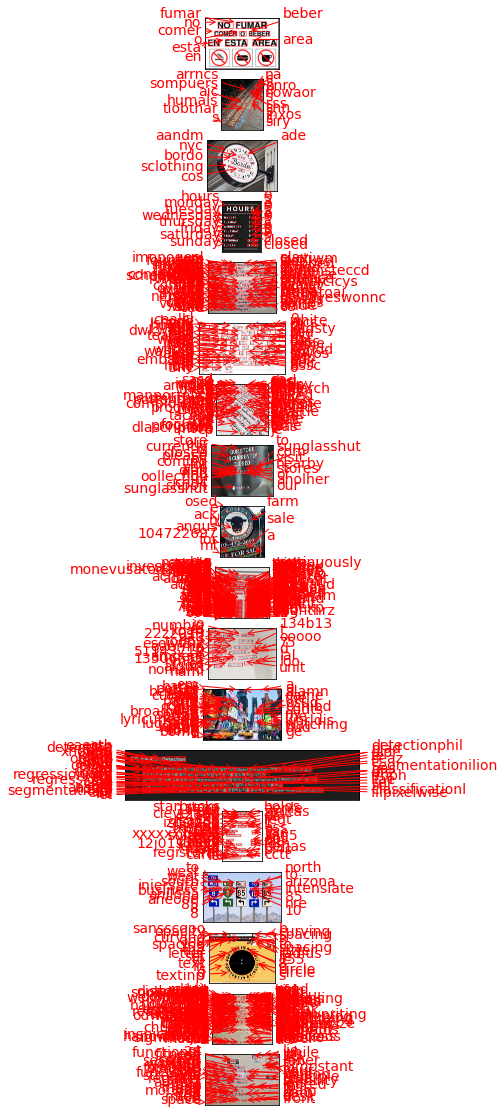

In [42]:
# plot predictions _Bounding box 
# plot method1 _ Node 

fig, axs = plt.subplots(nrows = len(images), figsize = (20, 20))

for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image = images[idx], # drawAnnotations 리턴이 ax임 
    predictions = prediction_groups[idx][0], ax = ax) # url읽은 것의 첫번째 prediction값을 내놓으라는 것으로 이해됨 
    

# prediction_groups = [pipeline.recognize([url]) for url in image_urls] 


# # plot method2 _ Official Method
# # 공식홈페이지 method 

# fig, axs = plt.subplots(nrows = len(images), figsize = (20, 20))
# for ax, image, predictions in zip(axs, images, prediction_groups):
#     # keras_ocr.tools.drawAnnotations(image = image, predictions = predictions, ax = ax)
#     keras_ocr.tools.drawAnnotations(image = image, predictions = predictions[0], ax = ax) # 위와 같은 결과를 나오게 하려면 이렇게 해야 하는듯 


In [60]:
# 글자 추출 리스트화 

post_prediction_list = []

for image in images:
    predictions = pipeline.recognize(images=[image])[0]
    post_prediction_list.append([text for text, box in predictions])
    # print('Predicted:', post_prediction_list)
    

In [66]:
# 추출된 word만 모아 pd화 시킴 

import pandas as pd

post_prediction_list
post_prediction_df = pd.DataFrame(post_prediction_list)
post_prediction_df

,0,1,2,3,4,5,6,7,8,9,...,261,262,263,264,265,266,267,268,269,270
0,fumar,no,comer,beber,o,esta,area,en,None,None,...,None,None,None,None,None,None,None,None,None,None
1,na,s,s,e,onro,nowaor,s,,sss,snn,...,None,None,None,None,None,None,None,None,None,None
2,aandm,ade,nyc,bordo,sclothing,cos,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,hours,9,5,monday,e,9,5,tuesday,e,9,...,None,None,None,None,None,None,None,None,None,None
4,imonogecl,to,wm,elay,cuctiwm,last,weekss,om,fora,wh,...,None,None,None,None,None,None,None,None,None,None
5,cl,9,ceally,hope,white,cb,to,mcs,pou,di,...,None,None,None,None,None,None,None,None,None,None
6,e,sasd,se,md,so,sos,dad,cas,a,inend,...,None,None,None,None,None,None,None,None,None,None
7,store,our,currently,is,closed,to,com,sunglasshut,visit,please,...,None,None,None,None,None,None,None,None,None,None
8,osed,farm,e,n,ack,angus,104722697,sale,for,ml,...,None,None,None,None,None,None,None,None,None,None
9,nasdaq,8,amex,stocks,in,bold,fell,50,tose,or,...,90,080,302,o02,s,sn,ce,d,co,


## **2. Tesseract | OCR 두번째 방법**

- 구글에서 후원하는 OCR 오픈소스 라이브러리로
- 버전 4에서는 LSTM이 엔진에 추가, 버전 5도 존재 
- python wrapper -> pytesseracrt 존재 

### 1. Anaconda에서 tesseract 설치 | pytesseract 이용
`conda install -c conda-forge pytesseract` 설치   

Python-tesseract is an optical character recognition (OCR) tool for python. That is, it will recognize and “read” the text embedded in images.

Python-tesseract is a wrapper for Google’s Tesseract-OCR Engine. It is also useful as a stand-alone invocation script to tesseract, as it can read all image types supported by the Pillow and Leptonica imaging libraries, including jpeg, png, gif, bmp, tiff, and others. Additionally, if used as a script, Python-tesseract will print the recognized text instead of writing it to a file.

- [Pytesseract](https://pypi.org/project/pytesseract/)  

#### Anaconda 내 pytesseract 설치 및 import 했음에도 불구하고 에러가 뜸 -> 해결방법  

- [참고페이지](https://pythonforundergradengineers.com/how-to-install-pytesseract.html)  
- 아래와 같은 방법으로 진행하라고 함  

***[방법1]***  

    1. install tesseract
    2. figure out where the tesseract executable is located  
        - where pytesseract
        - /opt/anaconda3/envs/tf2/bin/pytesseract
        - `pytesseract.pytesseract.tesseract_cmd = r'Users/js8456/opt/anaconda3/envs/tf2/bin/pytesseract'`
- 근데 이거 안먹힘 -> 그래서 다른 방법으로 넘어감 


***[방법2]*** 
brew install tesseract
- macos에서는 꼭 brew로 다운을 받아야 한다고 함 
- [참고페이지](https://guides.library.illinois.edu/c.php?g=347520&p=4121425)

#### 언어 다운로드 
- 버전 4와 버전 5의 train data가 다르기 때문에 버전을 확인해야 하는데 pytesserract가 어떤 tesseract의 버전을 사용하는지 확실히 모르겠음 
1. 언어별 trained data를 따로 download 받는다 
    - https://tesseract-ocr.github.io/tessdoc/Data-Files # 버전 4
    - https://github.com/tesseract-ocr/tessdata_best # 얘가 버전5 
2. $ sudo apt install tesseract-ocr-kor
    - sudo 방식으로 다운받는다 
3. sudo apt install tesseract-ocr-all로 모든 언어를 다운받는다   

우선 210918 지금은 영어를 사용할테니, 아무것도 진행하지 않도록 함 
우선 아래와같은 language가 존재한다는 것을 확인할 수 있음(다운은 받아야하지만)  


In [ ]:
pytesseract.__version__

In [32]:
import pytesseract
from PIL import Image
from pytesseract import Output

### OEM & PSM 세팅 내용 
# OCR Engine modes(–oem):
# 0 - Legacy engine only. -> 한글 안됨
# 1 - Neural nets LSTM engine only. -> 한글 인식
# 2 - Legacy + LSTM engines. -> 한글 안됨
# 3 - Default, based on what is available. -> 한글 인식 

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only. / 방향 및 스크립트 감지 
# 1 - Automatic page segmentation with OSD. / osd로 페이지 자동 분할
# 2 - Automatic page segmentation, but no OSD, or OCR. / 자동 페이지 분할이나 osd, ocr없음
# 3 - Fully automatic page segmentation, but no OSD. (Default) / 완전 자동으로 페이지 분할 osd는 없음 
# 4 - Assume a single column of text of variable sizes. / 한글인식 가능 / 가변적 크기의 한개의 텍스트 열이라 가정
# 5 - Assume a single uniform block of vertically aligned text. / 수직으로 쓰이는 텍스트(일본어같이)
# 6 - Assume a single uniform block of text. / 한글 인식/ 균일한 텍스트 단일 블록이라 가정
# 7 - Treat the image as a single text line. / 이미지를 한개의 텍스트 라인으로 취급
# 8 - Treat the image as a single word. / 이미지를 한개의 단어로 취급 
# 9 - Treat the image as a single word in a circle. / 이미지를 한 원 안의 한 단어로 취급
# 10 - Treat the image as a single character. / 이미지를 한개의 문자로 취급 
# 11 - Sparse text. Find as much text as possible in no particular order. / 한글 인식/특정 순서 없이 가능한 많은 텍스트 찾기
# 12 - Sparse text with OSD. / 한글인식 / osd로 텍스트 분리 
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific./ 원시라인, 이미지를 한개의 텍스트 라인으로 


**[TIP] `image_to_data`**   

Returns result containing box boundaries, confidences, and other information. Requires Tesseract 3.05+. For more information, please check the Tesseract TSV documentation  

- image_to_data의 리턴이 어떤것이 나오는지 먼저 궁금해서 찾아봄  
- [참고페이지_Does anyone knows the meaning of output of image_to_data, image_to_osd methods of pytesseract?](https://stackoverflow.com/questions/61461520/does-anyone-knows-the-meaning-of-output-of-image-to-data-image-to-osd-methods-o)  

Column Level:  

Item with no block_num, paragraph_num, line_num, word_num  

Item with block_num and with no paragraph_num, line_num, word_num  

Item with block_num, paragraph_num and with no line_num, word_num  

Item with block_num, paragraph_num, line_num, and with no word_num  

Item with all those numbers


**[TIP] `image_to_box`**  
- [참고페이지](https://github.com/madmaze/pytesseract/blob/master/pytesseract/pytesseract.py)


In [ ]:
# def image_to_data(
#     image,
#     lang=None,
#     config='',
#     nice=0,
#     output_type=Output.STRING,
#     timeout=0,
#     pandas_config=None,
# ):
#     """
#     Returns string containing box boundaries, confidences,
#     and other information. Requires Tesseract 3.05+
#     """

#     if get_tesseract_version() < '3.05':
#         raise TSVNotSupported()

#     config = f'-c tessedit_create_tsv=1 {config.strip()}'
#     args = [image, 'tsv', lang, config, nice, timeout]

#     return {
#         Output.BYTES: lambda: run_and_get_output(*(args + [True])),
#         Output.DATAFRAME: lambda: get_pandas_output(
#             args + [True],
#             pandas_config,
#         ),
#         Output.DICT: lambda: file_to_dict(run_and_get_output(*args), '\t', -1),
#         Output.STRING: lambda: run_and_get_output(*args),
#     }[output_type]()


### 2. 문자 검출 | Detector

In [53]:
#### 문자 검출 부분 
# OCR(Optical Character Recognition, 광학 문자 인식)
# OSD(Orientation and script Detection)

def crop_word_regions(image_path = './images.sample.png', output_path = './output'):
    if not os.path.exists(output_path): # 1. output_path 파일 없으면 만들고 
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3' # 2. oem, psm과 같은 사용자 정의 구성이 필요한 경우 config 키워드 사용
    image = Image.open(image_path) # 3. 이미지 오픈 

    # 이미지 -> 데이터로 인식 
    recognized_data = pytesseract.image_to_data(
        image, lang = 'eng', # 한국어라면 lang = 'kor'
        config = custom_oem_psm_config, 
        output_type = Output.DICT
    ) # image_to_data 리턴값이 이미지를 저장해서 그거를 다시 file_to_dict로 얻은 결과인데 

    # print(recognized_data) # 테스트용으로 확인하고자 넣어놓음 

    top_level = max(recognized_data['level']) 

    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]

        if level == top_level: # recognized_data['level']에서 가장 큰 값이 level과 같으면 그 i를 이용해서 
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]

            output_img_path = os.path.join(output_path, f'{str(index).zfill(4)}.png') # 해당 이미지 저장 패스 
            print('output_img_path:', output_img_path)
            cropped_image = image.crop((
                left, 
                top,
                left+width, 
                top+height
            ))

            cropped_image.save(output_img_path) # 해당 이미지에 cropped_image 저장 
            cropped_image_path_list.append(output_img_path) # multiple image의 path 저장 
            index += 1 # i와 같은 값이겠지 
    return cropped_image_path_list

work_dir = os.getcwd() + '/test_image'

post_test_image_file = os.getcwd() + '/post_test_image_file'
# os.mkdir(post_test_image_file) # def에 os.mkdir 이미 있음 

img_file_path = work_dir + '/test_1.png'

cropped_image_path_list = crop_word_regions(img_file_path, post_test_image_file )
print(cropped_image_path_list) 


output_img_path: /Users/js8456/google_drive/Colab_Notebook/aiffel_lms/E18_OCR/post_test_image_file/0000.png
output_img_path: /Users/js8456/google_drive/Colab_Notebook/aiffel_lms/E18_OCR/post_test_image_file/0001.png
output_img_path: /Users/js8456/google_drive/Colab_Notebook/aiffel_lms/E18_OCR/post_test_image_file/0002.png
output_img_path: /Users/js8456/google_drive/Colab_Notebook/aiffel_lms/E18_OCR/post_test_image_file/0003.png
output_img_path: /Users/js8456/google_drive/Colab_Notebook/aiffel_lms/E18_OCR/post_test_image_file/0004.png
output_img_path: /Users/js8456/google_drive/Colab_Notebook/aiffel_lms/E18_OCR/post_test_image_file/0005.png
output_img_path: /Users/js8456/google_drive/Colab_Notebook/aiffel_lms/E18_OCR/post_test_image_file/0006.png
output_img_path: /Users/js8456/google_drive/Colab_Notebook/aiffel_lms/E18_OCR/post_test_image_file/0007.png
output_img_path: /Users/js8456/google_drive/Colab_Notebook/aiffel_lms/E18_OCR/post_test_image_file/0008.png
['/Users/js8456/google_drive

In [ ]:
#### 문자 검출 부분 | Multiple images
# OCR(Optical Character Recognition, 광학 문자 인식)
# OSD(Orientation and script Detection)
# path_dir = '/Users/js8456/google_drive/Colab_Notebook/aiffel_lms/E18_OCR/test_image'
# image_path = sorted(os.listdir(path_dir))

pytesse_post_word_list = []

def crop_word_regions(image_path = image_path_list, output_path = './output'):
    if not os.path.exists(output_path): # 1. output_path 파일 없으면 만들고 
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3' # 2. oem, psm과 같은 사용자 정의 구성이 필요한 경우 config 키워드 사용
        
    for num, im in enumerate(image_path):    
        image = Image.open(im) # 3. 이미지 오픈 
        # print(im)
        # 이미지 -> 데이터로 인식 
        recognized_data = pytesseract.image_to_data(
            image, lang = 'eng', # 한국어라면 lang = 'kor'
            config = custom_oem_psm_config, 
            output_type = Output.DICT
        )

        top_level = max(recognized_data['level']) 

        index = 0
        cropped_image_path_list = []
        for i in range(len(recognized_data['level'])):
            level = recognized_data['level'][i]

            if level == top_level: # recognized_data['level']에서 가장 큰 값이 level과 같으면 그 i를 이용해서 
                left = recognized_data['left'][i]
                top = recognized_data['top'][i]
                width = recognized_data['width'][i]
                height = recognized_data['height'][i]

                output_img_path = os.path.join(output_path, f'{num, str(index).zfill(4)}.png') # 해당 이미지 저장 패스 
                print('output_img_path:', output_img_path)
                cropped_image = image.crop((
                    left, 
                    top,
                    left+width, 
                    top+height
                ))

                cropped_image.save(output_img_path) # 해당 이미지에 cropped_image 저장 
                cropped_image_path_list.append(output_img_path) # multiple image의 path 저장 
                index += 1 # i와 같은 값이겠지 
    return cropped_image_path_list

post_test_image_file = os.getcwd() + '/post_test_image_file'

cropped_image_path_list = crop_word_regions(image_path_list, post_test_image_file)
# print(cropped_image_path_list) 


------------
------------

### 3. 잘린 이미지에서 단어 인식 | Recognizer   

검출된 바운딩 박스 별로 잘린 이미지를 넣어주면 영역별 텍스트가 결괏값으로 나오는 image_to_string()를 사용  



In [86]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    pytess_post_word_list = []

    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        pytess_post_word_list.append(recognized_data['text'])
    print(pytess_post_word_list)

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

['\x0c', '\x0c', 'Kel\n\x0c', 'Nene\n\x0c', 'ee\n\x0c', 'ee\n\x0c', 'Functional\n\x0c', 'Fitness\n\x0c', '(8S)\n\x0c', 'SQ\n\x0c', 'TYvIT)\n\x0c', '2CSSIONS\n\x0c', '$199\n\x0c', 'per\n\x0c', 'person\n\x0c', 'circuit\n\x0c', 'based\n\x0c', 'workout\n\x0c', 'with\n\x0c', 'multiple\n\x0c', 'stations\n\x0c', 'focusing\n\x0c', 'Or)\n\x0c', 'core\n\x0c', 'stability\n\x0c', 'and\n\x0c', 'Founctiona!\n\x0c', 'Strength.\n\x0c', 'aregister\n\x0c', 'early:\n\x0c', 'class\n\x0c', 'iS\n\x0c', 'limited\n\x0c', 'to\n\x0c', 'iol*\n\x0c', 'june\n\x0c', '2? |\n\x0c', 'august\n\x0c', '1/\n\x0c', 'monday\n\x0c', 'ana\n\x0c', 'friday\n\x0c', 'Gam\n\x0c', '—\n\x0c', 'lidOam\n\x0c', '"1\n\x0c', '\x0c', '1S\n\x0c', 'im:ted-\n\x0c', 'sign\n\x0c', 'i>\n\x0c', 'at\n\x0c', '\x0c', 'front\n\x0c', 'desk UW\n\x0c', 'uC\n\x0c', 'nm\n\x0c', ':\n\x0c', '=\n\x0c', '_—\n\x0c', 'IP\n\x0c', 'anak\n\x0c', '«?\n\x0c', 'framner\n\x0c', 'Jumps tar?\n\x0c', 'your\n\x0c', 'ret\n\x0c']


----------
----------

### 회고 
- 전체적인 결과는 keras_ocr이 더 나은 겲과를 보임 
- pytesseract은 손글씨를 아예 인식하지 못하는 경우가 존재 
- 그러나 keras_ocr은 글자가 평행한 모양으로 기재되지 않는 경우 (네모난 박스에 들어가지 않는 경우) 정확한 인식을 하지 못함 
- 두 ocr 방법 모두 자체적인 training을 진행해야 더 나은 결과값을 보일 것 같음 